In [1]:
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from shapely.geometry import Polygon
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from shapely.validation import make_valid
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

In [2]:
train_df_ori= gpd.read_file("/Users/ahmed/Downloads/train.geojson")
test_df_ori = gpd.read_file("/Users/ahmed/Downloads/test.geojson")


In [3]:
train_df=train_df_ori.copy()
test_df=test_df_ori.copy()

traitement donnee train_df

In [4]:
#combler les valeurs manquantes
# Remplacement des valeurs NA par la moyenne des colonnes numériques
# Sélectionner uniquement les colonnes numériques
num_cols = train_df.select_dtypes(include=['number'])

# Remplacer les valeurs NA uniquement dans ces colonnes
train_df[num_cols.columns] = num_cols.fillna(num_cols.median())

# Remplacement de "N,A" par NaN dans toutes les colonnes categorique
train_df.replace("N,A", np.nan, inplace=True)

In [5]:
#remplacer NaN par inconnu pour urban_type
train_df['urban_type'].fillna("Inconnu")

# Remplacer les NaN par "Inconnu" avant de faire le One-Hot Encoding
train_df['urban_type'] = train_df['urban_type'].fillna("Inconnu")

# Appliquer le One-Hot Encoding en séparant les valeurs multiples
urban_types = train_df['urban_type'].str.get_dummies(sep=',')

# Ajouter ces nouvelles colonnes au DataFrame
train_df = pd.concat([train_df, urban_types], axis=1)


In [6]:
# Remplacer les NaN par "Inconnu_geo" correctement
train_df['geography_type'] = train_df['geography_type'].fillna("Inconnu_geo")

# Appliquer le One-Hot Encoding en séparant les valeurs multiples

geography_type = train_df['geography_type'].str.get_dummies(sep=',')
train_df = pd.concat([train_df, geography_type], axis=1)



In [7]:
# Convertir les colonnes de dates en format datetime
date_cols = ['date0', 'date1', 'date2', 'date3', 'date4']
train_df[date_cols] = train_df[date_cols].apply(pd.to_datetime, errors='coerce', format='%d-%m-%Y')

# Colonnes des statuts
status_cols = ['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']

# Trier les dates et réorganiser les statuts pour chaque ligne
sorted_dates = []
sorted_statuses = []

for i, row in train_df.iterrows():
    # Extraire les dates et statuts correspondants
    dates = row[date_cols].values
    statuses = row[status_cols].values

    # Trier les dates et réorganiser les statuts en conséquence
    sorted_pairs = sorted(zip(dates, statuses), key=lambda x: (x[0], x[0] is not pd.NaT))  # Trie par date, ignore NaT
    sorted_dates.append([pair[0] for pair in sorted_pairs])
    sorted_statuses.append([pair[1] for pair in sorted_pairs])

# Convertir les nouvelles dates triées en DataFrame
sorted_dates_df = pd.DataFrame(sorted_dates, columns=date_cols)
sorted_statuses_df = pd.DataFrame(sorted_statuses, columns=status_cols)

# Remplacer les anciennes valeurs par les nouvelles valeurs triées
train_df[date_cols] = sorted_dates_df
train_df[status_cols] = sorted_statuses_df

In [8]:
status_order = {
    "Greenland": 0, 
    "Prior Construction": 1, 
    "Land Cleared": 2, 
    "Excavation": 3,
    "Construction Started": 4, 
    "Materials Dumped": 5, 
    "Materials Introduced": 6,
    "Construction Midway": 7,
    "Construction Done": 8,
    "Operational": 9
}
for col in status_cols:
    train_df[col] = train_df[col].map(status_order)


In [9]:
for col in status_cols:
    train_df = train_df.dropna(subset=[col])  # Supprime les lignes avec NaN dans la colonne
    train_df.loc[:, col] = train_df[col].astype(int)  # Conversion propre en int


In [10]:
# Supprimer les géométries NULL ou NaN
train_df = train_df.dropna(subset=["geometry"])


# Filtrer uniquement les Polygons et MultiPolygons
train_df = train_df[train_df.geometry.type.isin(["Polygon", "MultiPolygon"])]

#  Supprimer les géométries invalides
train_df = train_df[train_df.is_valid]

# Supprimer les géométries vides (cela peut arriver après `dropna`)
train_df = train_df[~train_df.geometry.is_empty]

# Convertir en système métrique (EPSG:3857)
train_df = train_df.to_crs(epsg=3857)

# Vérifier qu'il ne reste que des géométries valides
train_df = train_df[train_df.is_valid & ~train_df.geometry.is_empty]

# Calculer l'aire et le périmètre
train_df["area_m2"] = train_df.geometry.area

train_df["perimeter_m"] = train_df.geometry.length


In [11]:
train_df["compactness"] = (4 * 3.14159 * train_df["area_m2"]) / (train_df["perimeter_m"] ** 2)


In [12]:
for i in range(len(date_cols) - 1):
    col1, col2 = date_cols[i], date_cols[i + 1]
    train_df[f"days_between_{col1}_{col2}"] = (train_df[col2] - train_df[col1]).dt.days


traitement donnee test_df

In [13]:
test_df.replace("N,A", np.nan, inplace=True)

In [14]:
test_df["urban_type"]=test_df["urban_type"].fillna("inconnu")
test_df["geography_type"]=test_df["geography_type"].fillna("inconnu_geo")
# Appliquer le One-Hot Encoding en séparant les valeurs multiples
urban_types = test_df['urban_type'].str.get_dummies(sep=',')

# Ajouter ces nouvelles colonnes au DataFrame
test_df = pd.concat([test_df, urban_types], axis=1)

In [15]:
# Appliquer le One-Hot Encoding en séparant les valeurs multiples
geography_type = test_df['geography_type'].str.get_dummies(sep=',')

# Ajouter ces nouvelles colonnes au DataFrame
test_df = pd.concat([test_df, geography_type], axis=1)

In [16]:
# Convertir les colonnes de dates en format datetime
date_cols = ['date0', 'date1', 'date2', 'date3', 'date4']
test_df[date_cols] = test_df[date_cols].apply(pd.to_datetime, errors='coerce', format='%d-%m-%Y')

# Colonnes des statuts
status_cols = ['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']

# Trier les dates et réorganiser les statuts pour chaque ligne
sorted_dates2 = []
sorted_statuses2 = []

for i, row in test_df.iterrows():
    # Extraire les dates et statuts correspondants
    dates = row[date_cols].values
    statuses = row[status_cols].values

    # Trier les dates et réorganiser les statuts en conséquence
    sorted_pairs = sorted(zip(dates, statuses), key=lambda x: (x[0], x[0] is not pd.NaT))  # Trie par date, ignore NaT
    sorted_dates2.append([pair[0] for pair in sorted_pairs])
    sorted_statuses2.append([pair[1] for pair in sorted_pairs])

# Convertir les nouvelles dates triées en DataFrame
sorted_dates_df = pd.DataFrame(sorted_dates2, columns=date_cols)
sorted_statuses_df = pd.DataFrame(sorted_statuses2, columns=status_cols)

# Remplacer les anciennes valeurs par les nouvelles valeurs triées
test_df[date_cols] = sorted_dates_df
test_df[status_cols] = sorted_statuses_df


In [17]:
for i in range(len(date_cols) - 1):
    col1, col2 = date_cols[i], date_cols[i + 1]
    test_df[f"days_between_{col1}_{col2}"] = (test_df[col2] - test_df[col1]).dt.days

In [18]:
#imputation par la valeur la plus frequente
cat_cols = test_df.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])



In [19]:
status_order = {
    "Greenland": 0, 
    "Prior Construction": 1, 
    "Land Cleared": 2, 
    "Excavation": 3,
    "Construction Started": 4, 
    "Materials Dumped": 5, 
    "Materials Introduced": 6,
    "Construction Midway": 7,
    "Construction Done": 8,
    "Operational": 9
}
for col in status_cols:
    test_df[col] = test_df[col].map(status_order)

In [20]:
# Convertir en système métrique (EPSG:3857)
test_df = test_df.to_crs(epsg=3857)

# Calculer l'aire et le périmètre
test_df["area_m2"] = test_df.geometry.area

test_df["perimeter_m"] = test_df.geometry.length

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shapely/measurement.py:44: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shapely/measurement.py:182: RuntimeWarning: invalid value encountered in length
  return lib.length(geometry, **kwargs)


In [21]:
test_df["compactness"] = (4 * 3.14159 * test_df["area_m2"]) / (test_df["perimeter_m"] ** 2)


In [22]:
# Sélectionner uniquement les colonnes numériques
num_cols = test_df.select_dtypes(include=['number'])

# Remplacer les valeurs NA uniquement dans ces colonnes
test_df[num_cols.columns] = num_cols.fillna(num_cols.median())

In [23]:
train_df_numeric = train_df[['change_type', 'img_red_mean_date1',
       'img_green_mean_date1', 'img_blue_mean_date1', 'img_red_std_date1',
       'img_green_std_date1', 'img_blue_std_date1', 'img_red_mean_date2',
       'img_green_mean_date2', 'img_blue_mean_date2', 'img_red_std_date2',
       'img_green_std_date2', 'img_blue_std_date2', 'img_red_mean_date3',
       'img_green_mean_date3', 'img_blue_mean_date3', 'img_red_std_date3',
       'img_green_std_date3', 'img_blue_std_date3', 'img_red_mean_date4',
       'img_green_mean_date4', 'img_blue_mean_date4', 'img_red_std_date4',
       'img_green_std_date4', 'img_blue_std_date4', 'img_red_mean_date5',
       'img_green_mean_date5', 'img_blue_mean_date5', 'img_red_std_date5',
       'img_green_std_date5', 'img_blue_std_date5','change_status_date0', 'change_status_date1','change_status_date2', 'change_status_date3',
       'change_status_date4', 'index','Dense Urban', 'Inconnu',
       'Industrial', 'Rural', 'Sparse Urban', 'Urban Slum', 'Barren Land',
       'Coastal', 'Dense Forest', 'Desert', 'Farms', 'Grass Land', 'Hills',
       'Inconnu_geo', 'Lakes', 'River', 'Snow', 'Sparse Forest', 'area_m2',
       'perimeter_m', 'compactness', 'days_between_date0_date1',
       'days_between_date1_date2', 'days_between_date2_date3',
       'days_between_date3_date4']]

Choix des features

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

X = train_df_numeric.drop(columns=["change_type"])  
y = train_df_numeric["change_type"]
y = y.map(change_type_map)
# Sélection des 25 meilleures features
selector = SelectKBest(score_func=f_classif, k=35)
X_new = selector.fit_transform(X, y)

# Voir les features sélectionnées
selected_features = X.columns[selector.get_support()]
print("📌 Features sélectionnées :", selected_features)

📌 Features sélectionnées : Index(['img_red_std_date1', 'img_green_std_date1', 'img_blue_std_date1',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5', 'change_status_date0', 'change_status_date1',
       'change_status_date2', 'change_status_date3', 'change_status_date4',
       'Dense Urban', 'Industrial', 'Barren Land', 'River', 'compactness',
       'days_between_date1_date2', 'days_between_date2_date3',
       'days_between_date3_date4'],
      dtype='object')


In [25]:
X = train_df_numeric[['img_red_std_date1', 'img_green_std_date1', 'img_blue_std_date1',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5', 'change_status_date0', 'change_status_date1',
       'change_status_date2', 'change_status_date3', 'change_status_date4',
       'Dense Urban', 'Industrial', 'Barren Land', 'River', 'compactness',
       'days_between_date1_date2', 'days_between_date2_date3',
       'days_between_date3_date4']]
           
X_test= test_df[['img_red_std_date1', 'img_green_std_date1', 'img_blue_std_date1',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5', 'change_status_date0', 'change_status_date1',
       'change_status_date2', 'change_status_date3', 'change_status_date4',
       'Dense Urban', 'Industrial', 'Barren Land', 'River', 'compactness',
       'days_between_date1_date2', 'days_between_date2_date3',
       'days_between_date3_date4']]
#Séparer en données d'entraînement (80%) et de test (20%)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)


#print(f"Taille jeu d'entraînement : {X_train.shape}")
#print(f"Taille jeu de test        : {X_test.shape}")

Random Forest

In [36]:
# Instancier un Random Forest
rf_model = RandomForestClassifier(
    n_estimators=120,  # Nombre d'arbres
    max_depth=38,      # Profondeur max (pour éviter le sur-apprentissage)
    random_state=45,
    n_jobs=-1          # Utilise tous les coeurs du processeur
)

rf_model.fit(X, y)

# Prédictions sur le set de test
y_pred = rf_model.predict(X_test)

#Calcul de la précision
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Précision du modèle Random Forest : {accuracy:.4f}")

#Rapport de classification détaillé
#print(classification_report(y_test, y_pred))


In [38]:
y_pred = rf_model.predict(X_test)
# Calcul de la précision
#accuracy = accuracy_score(y, y_pred)
#print(f"Précision du modèle Random Forest : {accuracy:.4f}")

# Rapport de classification détaillé
#print(classification_report(y_test, y_pred))

In [39]:
## Save results to submission file
pred_df = pd.DataFrame(y_pred, columns=['change_type'])
pred_df.to_csv("rf_sample_submission.csv", index=True, index_label='Id')

In [40]:
y_pred

array([3, 2, 2, ..., 3, 2, 2], shape=(120526,))

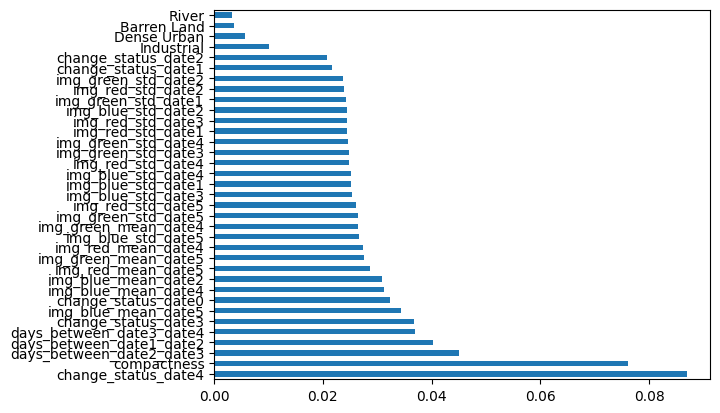

In [42]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(35).plot(kind='barh')
plt.show()

In [159]:
# Calculer la matrice de corrélation
correlation_matrix = X_train.corr().abs()

# Liste pour stocker les paires fortement corrélées
high_corr_pairs = []

# Trouver les paires fortement corrélées (corrélation > 0.9)
for i in range(len(correlation_matrix.columns)):
    for j in range(i):  # Éviter la diagonale et les doublons
        if correlation_matrix.iloc[i, j] > 0.9:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((feature1, feature2, corr_value))

# Convertir en DataFrame pour affichage propre
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
high_corr_df.sort_values(by="Correlation", ascending=False, inplace=True)


Adaboost

In [225]:
# Création du modèle AdaBoost avec un arbre de décision comme estimateur faible
base_learner = DecisionTreeClassifier(max_depth=1)
adaboost = AdaBoostClassifier(estimator=base_learner, n_estimators=120, learning_rate=0.2, random_state=42)

In [226]:
# Entraînement du modèle
adaboost.fit(X, y)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.2, n_estimators=120, random_state=42)

In [227]:
# Prédiction et évaluation
y_pred = adaboost.predict(X)
accuracy = accuracy_score(y, y_pred)

print(f"Précision du modèle AdaBoost : {accuracy:.2f}")

Précision du modèle AdaBoost : 0.56


XGBoost

In [42]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1100, learning_rate=0.1, max_depth=12)
xgb.fit(X, y)
print(xgb.score(X, y))


0.9969598255381449


In [43]:
y_pred=xgb.predict(X_test)

In [40]:
y_pred

array([3, 2, 2, ..., 3, 3, 3], shape=(120526,))

In [44]:
## Save results to submission file
pred_df = pd.DataFrame(y_pred, columns=['change_type'])
pred_df.to_csv("xgb_sample_submission.csv", index=True, index_label='Id')

In [244]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
# Meta-model : Logistic Regression
meta_model = LogisticRegression()

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf_model)],
    final_estimator=meta_model  # Le modèle final combine les résultats de XGBoost et RF
)

# Entraînement et évaluation
stacking_clf.fit(X, y)
y_pred = stacking_clf.predict(X)
print(f"Précision Stacking Classifier : {accuracy_score(y, y_pred):.2f}")

Précision Stacking Classifier : 0.99


In [245]:
y_pred = stacking_clf.predict(X_test)

In [246]:
## Save results to submission file
pred_df = pd.DataFrame(y_pred, columns=['change_type'])
pred_df.to_csv("xgb_rf_sample_submission.csv", index=True, index_label='Id')

NN

In [ ]:
## Train a simple OnveVsRestClassifier using featurized data
neigh = KNeighborsClassifier(n_neighbors=13)
neigh.fit(X, y)
pred_y = neigh.predict(X)
accuracy = accuracy_score(y, pred_y)

In [ ]:
accuracy

Reseau de neuronne

In [51]:
from sklearn.neural_network import MLPClassifier

In [52]:
# 🔹 5. Normalisation des features (important pour MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test2 = scaler.transform(X_test)

In [ ]:
# Création du MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(1024, 512, 256, 128),  # 4 couches plus profondes
    activation='relu',
    solver='adam',
    alpha=1e-2,               # Très faible régularisation
    learning_rate='adaptive',
    learning_rate_init=0.005,
    max_iter=2000,            # Plus d'itérations
    batch_size=128,
    early_stopping=False,     # On désactive l'early stopping pour sur-apprendre
    random_state=42
)


# Entraînement du modèle
mlp.fit(X_train, y)

# Prédictions
y_pred = mlp.predict(X_test2)

In [64]:
# Évaluation du modèle
accuracy = accuracy_score(y, y_pred)
print(f"Précision sur le test : {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y, y_pred))

Précision sur le test : 0.7675

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84     31356
           1       0.80      0.69      0.74     14186
           2       0.81      0.80      0.80    147483
           3       0.70      0.70      0.70     99911
           4       0.56      0.05      0.10      1309
           5       0.00      0.00      0.00       146

    accuracy                           0.77    294391
   macro avg       0.61      0.53      0.53    294391
weighted avg       0.77      0.77      0.77    294391



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [63]:
# Prédictions
y_pred = mlp.predict(X_train)

Regression logistique

In [26]:
from sklearn.linear_model import LogisticRegression


In [27]:
# Normalisation des données (optionnel mais souvent utile)
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test2 = scaler.transform(X_test)


In [35]:
log_reg = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs',          # ou 'saga' si tu as un dataset très volumineux
    class_weight='balanced',
    C=100.0,  # C plus grand réduit la régularisation
    max_iter=500,            # augmente si la convergence n’est pas atteinte
    random_state=42
)

In [36]:
# Entraînement du modèle
log_reg.fit(X_train, y)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=100.0, class_weight='balanced', max_iter=500,
                   multi_class='multinomial', random_state=42)

In [37]:
# 8️⃣ Prédictions
y_pred = log_reg.predict(X_train)

# 9️⃣ Évaluation
acc = accuracy_score(y, y_pred)
print("Accuracy :", acc)

print("\nClassification Report:\n", classification_report(y, y_pred))

Accuracy : 0.40567136902962386

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.77      0.49     31356
           1       0.31      0.73      0.43     14186
           2       0.72      0.40      0.51    147483
           3       0.58      0.25      0.35     99911
           4       0.02      0.58      0.04      1309
           5       0.00      0.45      0.00       146

    accuracy                           0.41    294391
   macro avg       0.33      0.53      0.31    294391
weighted avg       0.61      0.41      0.45    294391

